In [141]:
pwd

'/Users/admin/git_projects/football/notebooks'

In [1]:
import sys
import os

# If your notebook is in the same directory as the 'data_collector' module, you can use:
# root_path = os.getcwd()

# If you need to go up one directory from the notebook's location, you can use:
root_path = os.path.dirname(os.getcwd())

sys.path.append(root_path)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from data_collection.data_collector import DataCollector


In [2]:
df = pd.read_csv("/Users/admin/git_projects/football/data_collection/serie_a.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7619 entries, 0 to 7618
Columns: 157 entries, game_id to lon
dtypes: datetime64[ns](1), float64(146), object(10)
memory usage: 9.1+ MB


/var/folders/cz/tsrtpglj4x3fc4dskw2pnjrc0000gn/T/ipykernel_26075/3339671743.py:1: DtypeWarning: Columns (49,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/admin/git_projects/football/data_collection/serie_a.csv")
/var/folders/cz/tsrtpglj4x3fc4dskw2pnjrc0000gn/T/ipykernel_26075/3339671743.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


# Summary Metrics by Team

In [3]:
dc = DataCollector()

dc.compute_team_statistics(df)


,HomeTeam,HomeGames,HomeWins,HomeDraws,HomeGoals,AwayGames,AwayWins,AwayDraws,AwayGoals,TotalGames,TotalWins,TotalDraws,TotalGoals,WinRatio,DrawRatio,HomeWinRatio,AwayWinRatio,HomeGoalRatio,AwayGoalRatio,TotalGoalRatio
0,Ancona,12,2,4,9.0,10,0,0,8.0,22,2,4,17.0,0.090909,0.181818,0.166667,0.000000,0.750000,0.800000,0.772727
1,Ascoli,38,10,16,51.0,38,4,12,28.0,76,14,28,79.0,0.184211,0.368421,0.263158,0.105263,1.342105,0.736842,1.039474
2,Atalanta,333,155,89,552.0,331,105,88,426.0,664,260,177,978.0,0.391566,0.266566,0.465465,0.317221,1.657658,1.287009,1.472892
3,Bari,38,13,10,42.0,38,5,10,34.0,76,18,20,76.0,0.236842,0.263158,0.342105,0.131579,1.105263,0.894737,1.000000
4,Benevento,38,7,9,42.0,38,6,6,31.0,76,13,15,73.0,0.171053,0.197368,0.184211,0.157895,1.105263,0.815789,0.960526
5,Bologna,305,113,86,403.0,305,66,87,294.0,610,179,173,697.0,0.293443,0.283607,0.370492,0.216393,1.321311,0.963934,1.142623
6,Brescia,64,17,18,78.0,65,12,14,62.0,129,29,32,140.0,0.224806,0.248062,0.265625,0.184615,1.218750,0.953846,1.085271
7,Cagliari,332,126,93,442.0,333,54,93,311.0,665,180,186,753.0,0.270677,0.279699,0.379518,0.162162,1.331325,0.933934,1.132331
8,Carpi,19,6,5,23.0,19,3,6,14.0,38,9,11,37.0,0.236842,0.289474,0.315789,0.157895,1.210526,0.736842,0.973684
9,Catania,152,73,39,206.0,152,13,51,129.0,304,86,90,335.0,0.282895,0.296053,0.480263,0.085526,1.355263,0.848684,1.101974


## Distributions

In [61]:
df.head()

,game_id,Div,Date,HomeTeam,TG,AwayTeam,FTHG,FTAG,FTR,HTHG,...,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,season,city_name,lat,lon,Year
0,9756db2e,serie_a,2003-08-30,Reggina,4.0,Sampdoria,2.0,2.0,D,2.0,...,NaN,NaN,NaN,NaN,NaN,2003/2004,Reggio Calabria,38.103539,15.639756,2003.0
1,e4604038,serie_a,2003-08-31,Bologna,4.0,Parma,2.0,2.0,D,1.0,...,NaN,NaN,NaN,NaN,NaN,2003/2004,Bologna,44.493820,11.342633,2003.0
2,e4be3e26,serie_a,2003-08-31,Brescia,2.0,Chievo,1.0,1.0,D,0.0,...,NaN,NaN,NaN,NaN,NaN,2003/2004,Brescia,45.779580,10.425873,2003.0
3,22af961b,serie_a,2003-08-31,Inter,2.0,Modena,2.0,0.0,H,0.0,...,NaN,NaN,NaN,NaN,NaN,2003/2004,Milano,45.464194,9.189635,2003.0
4,e6bf6b52,serie_a,2003-08-31,Juventus,6.0,Empoli,5.0,1.0,H,1.0,...,NaN,NaN,NaN,NaN,NaN,2003/2004,Torino,45.067755,7.682489,2003.0


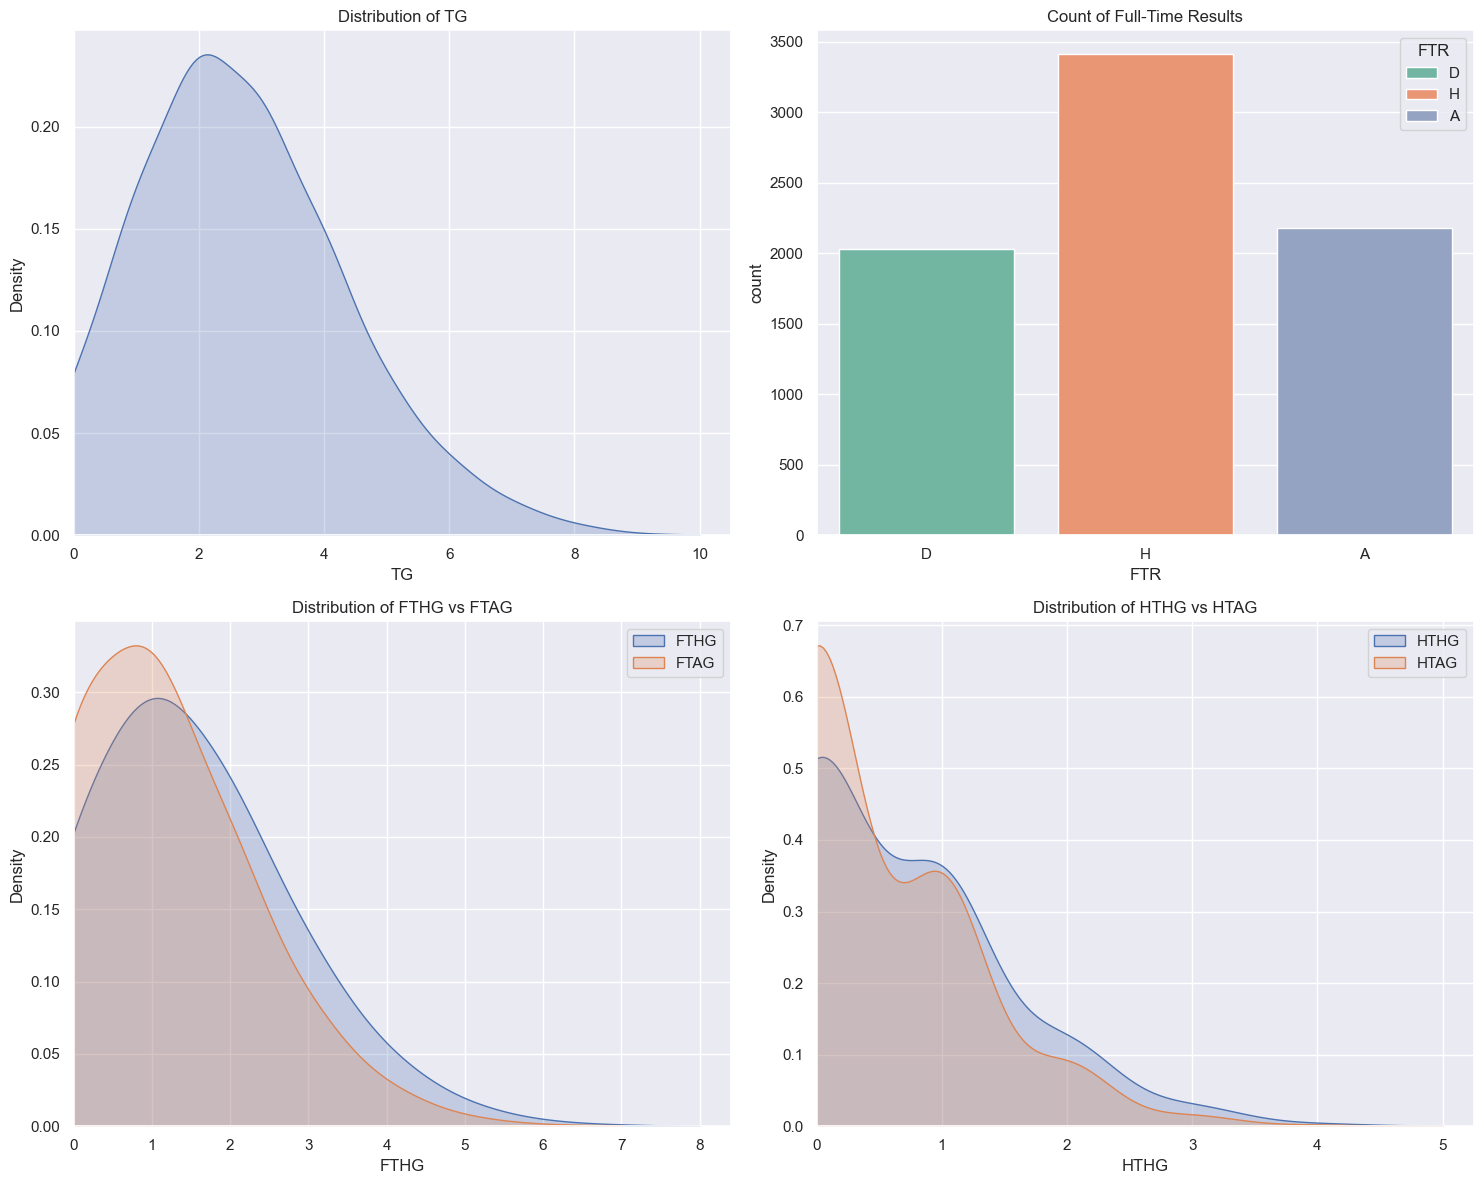

In [92]:
sns.set_theme()

f, axes = plt.subplots(2, 2, figsize=(15, 12))  # Adjusted figsize for better visibility

# KDE plot for 'TG'
sns.kdeplot(data=df, x='TG', cut=0, bw_adjust=2, ax=axes[0, 0], fill=True)
axes[0, 0].set_xlim(left=0)
axes[0, 0].set_title('Distribution of TG')

# Count plot for 'FTR'
sns.countplot(data=df, x='FTR', hue='FTR', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Count of Full-Time Results')


sns.kdeplot(data=df, x='FTHG', ax=axes[1, 0], cut=0, bw_adjust=3, fill=True, label='FTHG')
sns.kdeplot(data=df, x='FTAG', ax=axes[1, 0], cut=0, bw_adjust=3, fill=True, label='FTAG')
axes[1, 0].set_xlim(left=0)
axes[1, 0].set_title('Distribution of FTHG vs FTAG')
axes[1, 0].legend()

sns.kdeplot(data=df, x='HTHG', ax=axes[1, 1], cut=0, bw_adjust=3, fill=True, label='HTHG')
sns.kdeplot(data=df, x='HTAG', ax=axes[1, 1], cut=0, bw_adjust=3, fill=True, label='HTAG')
axes[1, 1].set_xlim(left=0)
axes[1, 1].set_title('Distribution of HTHG vs HTAG')
axes[1, 1].legend()


# You can add another plot in axes[1, 1] as needed

plt.tight_layout()
plt.show()

HomeTeam
Inter          383
Lazio          381
Milan          381
Roma           380
Udinese        380
Fiorentina     371
Juventus       365
Sampdoria      348
Atalanta       333
Cagliari       332
Napoli         318
Bologna        305
Genoa          299
Torino         280
Chievo         273
Parma          254
Palermo        224
Sassuolo       204
Empoli         196
Verona         165
Siena          159
Lecce          156
Catania        152
Livorno        111
Reggina        101
Brescia         64
Cesena          57
Crotone         57
Spal            57
Spezia          57
Messina         53
Frosinone       52
Salernitana     52
Bari            38
Pescara         38
Ascoli          38
Benevento       38
Monza           33
Novara          19
Treviso         19
Carpi           19
Venezia         19
Cremonese       19
Modena          12
Ancona          12
Perugia         10
Name: count, dtype: int64

In [128]:
df['AwayTeam'].value_counts()

AwayTeam
Lazio          384
Inter          382
Roma           381
Milan          381
Udinese        380
Fiorentina     372
Juventus       364
Sampdoria      350
Cagliari       333
Atalanta       331
Napoli         318
Bologna        305
Genoa          299
Torino         280
Chievo         273
Parma          252
Palermo        224
Sassuolo       204
Empoli         195
Verona         167
Siena          159
Lecce          152
Catania        152
Livorno        110
Reggina        104
Brescia         65
Spal            57
Cesena          57
Crotone         57
Spezia          57
Messina         53
Frosinone       52
Salernitana     52
Bari            38
Benevento       38
Pescara         38
Ascoli          38
Monza           33
Carpi           19
Novara          19
Treviso         19
Venezia         19
Cremonese       19
Perugia         12
Modena          10
Ancona          10
Name: count, dtype: int64